# Import des fonctions

In [54]:
import pymongo
from pymongo import MongoClient
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

client = MongoClient()
collection = client.mention.data_mention

# Defintion de la classe de requête

Cette classe permet deux choses : Faire les requêtes en direct sur la database principale et visualiser le résultat ou de lancer une requête et sauvegarder son output sous forme d'une nouvelle table.

Description des sous fonctions : 

#### adding:

    Input:
    dico : un dictionnaire ajouté en première place du pipeline
    
    Fonction:
    Permet d'ajouter un paramètre en première position du pipeline d'aggregation, par exemple, un matching.
    ex: adding({'$match':{'Date':'20180102'}})
    
#### requete1:

    Input
    out : (default : False). Permet de sauvegarder la table de la requete si True.
    
    Fonction
    Affiche les événements (valeurs de la table events) qui y font référence (dans les derniers 6 mois).
    
#### requete2:

    Input
    out : (default : False). Permet de sauvegarder la table de la requete si True.
    Acteur : Nom d'un acteur pour filtrer la base de donnée
    Date : Date à partir de laquelle on filtre les 6 mois
    Plot : (default : False). Affiche le graph des évènement
    Filt : (default : 'W'). Paramètre d'aggregation des dates de pandas. Par défaut 'W' = week
    
    Fonction
    Affiche le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).
    
    
#### requete3:

    Input
    out : (default : False). Permet de sauvegarder la table de la requete si True.
    
    Fonction
    Trouve les sujets (acteurs) qui ont eu le plus d’articles positifs/negatifs pour chaque triplet (mois, pays, langue de l’article).
    
    
#### requete4:

    Input
    out : (default : False). Permet de sauvegarder la table de la requete si True.
    arg : ('Month', 'Date', 'Year') Permet de grouper les données suivant une échelle de temps
    top : La limite des sujets polémiques filtrés. Nombres d'entrées de la table final
    
    Fonction
    Trouve quels sont les acteurs/pays/organisations qui divisent le plus. Pour ce faire notre approche se base sur un recenssement des pays qui ont un ton positif ou negatif et regarde quelles sont les sujets qui ont le plus de partisants de chaque coté de l'opinion
    
    
#### requete5:

    Input
    pays1 : Premier pays pour la comparaison
    pays2 : La limite des sujets polémiques filtrés. Nombres d'entrées de la table final
    
    Fonction
    Compare l'évolution des relations entre deux pays suivant 5 thème prédéfinis
    

In [120]:
class Request:
    
    def __init__(self,db):
        self.data = db
        self.cons = []
        self.pipe = []
        
    def adding(self,dico):
        self.cons.append(dico)
        
    def pop(self):
        self.cons.pop(-1)
        
    def requete1(self,out=False):
        
        #Première projection : Pour optimiser la mémoire on ne garde que les colonnes qui nous intéressent
        project = {'Language' : 1,'Mention': 1, 'EventID': 1, 'Date':1, 'Actor1Country':1,'Actor2Country':1}

        #On merge les features Actor1Country et Actor2Country pour préparer le unwind
        project2 = {'Language' : 1,
                   'EventID': 1,
                   'Date':1,
                   'Mention.Language':1,
                   'Actor':['$Actor1Country','$Actor2Country']}

        #On groupby Langue/Date/Actor/Even. On compte chaque article associé
        group1 = {'_id': {'langue':'$Mention.Language',
                         'date':'$Date',
                         'actor':'$Actor',
                         'even' : '$EventID'
                        },
                 'num_article': {'$sum':1}
                 }
        #On prend ensuite la moyenne pour un triplet Date/Actor/Langue
        group2 = {'_id' : {'date': '$_id.date',
                          'actor': '$_id.actor',
                          'langue': '$_id.langue'
                         },
                 'avg' : {'$avg':'$num_article'},
                 }
        #
        match1 = {'_id.actor': { "$exists": True, "$ne": '' }}

        #On "sort" chaque champ qui nous intéresse de _id pour ensuite passage en DataFrame et visualisation
        project3 = {'Date':'$_id.date',
                    'Actor':'$_id.actor',
                    'Language':'$_id.langue',
                    'Mean':'$avg',
                    }



        #Requete final
        self.pipe = self.cons+[ {'$project': project},
                                {'$unwind': '$Mention'},
                                {'$project': project2},
                                {'$unwind': '$Actor'},
                                {'$group' : group1},
                                {'$match': match1},
                                {'$group': group2},
                                {'$project': project3}
                               ]
        
        if out:
            self.pipe.append({'$out':'req1'})
            
        self.req = self.data.aggregate(self.pipe , allowDiskUse= True )
        
        if not out:
            self.df = pd.DataFrame(list(self.req)).drop(columns=['_id'])
        
    def requete2(self,Acteur, Date, plot = False,Filt = 'W',out=False):

        # On ne garde que les documents dans lesquels l'acteur recherché est présent (dans actor1 ou actor2)
        match1 = {'$or':[{'Actor1Name': str(Acteur).upper()}, 
                         {'Actor2Name': str(Acteur).upper()}]}

        # On réduit les colonnes à celles dont ont aura besoin uniquement pour accélerer la requête
        project1 = {'EventID': 1,
                    'Date':{'$toDate': '$Date'},
                    'DiffDays':{'$divide':[{'$subtract':[{'$toDate': Date}, {'$toDate': '$Date'}]},1000 * 60 * 60 * 24]},
                    'Language':1,
                    'Actor':['$Actor1Name', '$Actor2Name']}

        # Après avoir transformé actor1 et actor2 en un seul champ Actor, on récupère les interlocuteurs et les events datant de moins de 6mois 
        match2 = {'$and':[{'Actor': {'$ne': str(Acteur).upper()}}, 
                          {'DiffDays': {'$lt':6*30}}]
                 }
        # On regroupe les données par eventID
        group1 = {'_id':{'Stakeholder':'$Actor','Event':'$EventID', 'Date':'$Date', 'Anciennete':'$DiffDays'}}

        # On stack l'id pour récupérer les champs en vue d'intégration dans un dataframe (pour visualisation)
        project2 = {'Stakeholder':'$_id.Stakeholder',
                    'Event':'$_id.Event',
                    'Date':'$_id.Date', 
                    'Anciennete':'$_id.DiffDays'}

        # Exécution de la requête
        self.pipe = self.cons+ [{'$match': match1},
                                     {'$project': project1},
                                     {'$unwind': '$Actor'},
                                     {'$match': match2},
                                     {'$group': group1},
                                     {'$project': project2},
                                     ]
        self.req = self.data.aggregate(self.pipe, allowDiskUse= True)
        
        # Result in a dataframe
        self.df = pd.DataFrame(list(self.req)).drop(columns=['_id'])
        
        if plot==True:
            reshap = self.df.groupby('Date').count()['Event'].resample(Filt).sum()
            plt.figure(figsize=(15,8))
            plt.title(f'number of events for {Acteur} by {Filt}', size= 20)
            sns.barplot(reshap.index,reshap.values),
            plt.xticks(rotation=90)
            plt.show()
            
    def requete3(self,out=False):
        project1 = {'Month' : 1,
                    'Mention': 1, 
                    'Actor1Name':1, 
                    'Actor2Name':1, 
                    'Actor1Country':1, 
                    'Actor2Country':1}

        project2 = {'Month' : 1,
                    'Language':'$Mention.Language', 
                    'INT_Tone': {
                                   '$convert':
                                      {
                                         'input': '$Mention.Tone',
                                         'to': 'double',
                                         'onError': 0, 
                                      }
                                } , 
                    'Actor1':{'Country':'$Actor1Country','Name':'$Actor1Name'}, 
                    'Actor2':{'Country':'$Actor2Country','Name':'$Actor2Name'}}

        project3 = {'Month' : 1,
                    'Language': 1,
                    'INT_Tone':1, 
                    'Actors' : ['$Actor1','$Actor2']}

        project4 = {'Name' : '$Actors.Name',
                   'Country': '$Actors.Country',
                   'Language' : 1,
                   'Month': 1,
                   'Pos': {'$cond': [{'$gt': ["$INT_Tone", 10]}, 1, 0]},
                   'Neg': {'$cond': [{'$lt': ["$INT_Tone", -10]}, 1, 0]},           
                   }

        group1 = {'_id': {'Month':'$Month','Country':'$Country','Language':'$Language', 'Actor':'$Name'},
                 'Count_tone_pos': {'$sum': '$Pos'}, 
                 'Count_tone_neg': {'$sum': '$Neg'}
                 }

        group2 = {
                     "_id": {'Month':'$_id.Month','Country':'$_id.Country','Language':'$_id.Language'},
                     "max_pos": { "$max": "$Count_tone_pos" },
                     "max_neg": { "$max": "$Count_tone_neg"},
                     "doc": { "$push": {
                           "_id": "$_id.Actor",
                           "name": "$id_.Actor",
                           "quantity_pos": "$Count_tone_pos",
                           "quantity_neg": "$Count_tone_neg"
                           }
                      }}
        project5 =  {
                        "_id":1,
                        "Most_Liked_Actor": {
                           "$setDifference": [
                              { "$map": {
                                  "input": "$doc",
                                  "as": "doc",
                                  "in": {
                                      "$cond": [
                                              { "$and": [{"$eq": [ "$max_pos", "$$doc.quantity_pos" ]},
                                                         {"$gt": ["$$doc.quantity_pos", 0 ]}] },
                                          "$$doc._id",
                                          False
                                      ]
                                  }
                              }},
                              [False]
                           ]
                       },
                           "Most_Disliked_Actor": {
                               "$setDifference": [
                                  { "$map": {
                                      "input": "$doc",
                                      "as": "doc",
                                      "in": {
                                          "$cond": [
                                              { "$and": [{"$eq": [ "$max_neg", "$$doc.quantity_neg" ]},
                                                         {"$gt": [ "$$doc.quantity_neg", 0 ]}] },
                                              "$$doc._id",
                                              False
                                          ]
                                      }
                                  }},
                                  [False]
                               ]
                           }
                   }
        project6 = {'Month':'$_id.Month',
                    'Country':'$_id.Country',
                    'Language':'$_id.Language',
                    'Most_Liked_Actor':1,
                    'Most_Disliked_Actor':1
                    }


        self.pipe = self.cons + [{'$match': {'Mention.Tone': { "$exists": True,
                                                              "$ne": ''}}},
                                    {'$project': project1},
                                    {'$unwind': '$Mention'},
                                    {'$project': project2},
                                    {'$project': project3},
                                    {'$unwind': '$Actors'},
                                    {'$match': {'Actors.Country': { "$exists": True, "$ne": '' }}},
                                    {'$match': {'Actors.Name': { "$exists": True, "$ne": '' }}},
                                    {'$project': project4},
                                    {'$match': {'$and' : [{'Name': { "$exists": True, "$ne": '' }}, {'$or':[{'Neg': 1},{'Pos':1}]}]}}, 
                                    {'$group': group1},
                                    {'$group':group2},
                                    {'$project': project5},
                                    {'$project': project6}
                                     ]
        if  out:
            self.pipe.append({'$out':'req3'})
            
        self.req = self.data.aggregate(self.pipe, allowDiskUse= True)
        
        if not out:
            df = pd.DataFrame(list(self.req)).drop(columns=['_id'])
            self.df = df
    
    def requete4(self, arg, top,out=False):

        #On projette sur les features utiles
        project1 = {f'{arg}' : f'${arg}',
                    'Mention': 1, 
                    'Actor1Name':1, 
                    'Actor2Name':1, 
                    'Actor1Country':1, 
                    'Actor2Country':1}

        #Cette phase de projection permet de convertir le ton en chiffre. Certaines valeurs
        #présentent un format inadapté. En cas d'erreur, on renvoit 0
        project2 = {f'{arg}' : 1,
                    'Language':'$Mention.Language', 
                    'INT_Tone': {
                                   '$convert':
                                      {
                                         'input': '$Mention.Tone',
                                         'to': 'double',
                                         'onError': 0, 
                                      }
                                } , 
                    'Actor1':{'Country':'$Actor1Country','Name':'$Actor1Name'}, 
                    'Actor2':{'Country':'$Actor2Country','Name':'$Actor2Name'}}

        #On creer une liste sur les actors pour pouvoir faire une opération d'unwind ensuite
        project3 = {f'{arg}' : 1,
                    'INT_Tone':1,
                    'Language':1,
                    'Actors' : ['$Actor1','$Actor2']}

        #On regarde si la l'article a une conotation positive ou négative
        project4 = {'Name' : '$Actors.Name',
                   'Language' : 1,
                   f'{arg}': 1,
                   'Pos': {'$cond': [{'$gt': ["$INT_Tone", 10]}, 1, 0]},
                   'Neg': {'$cond': [{'$lt': ["$INT_Tone", -10]}, 1, 0]},           
                   }
        
        #On calcul un ratio entre tons positifs et négatifs, cela nous permet de savoir
        #Pour un pays donné si le pays est perçu de manière positive ou négatif
        project5 = {'Ratio_pos' : {'$divide': [{'$add': [ "$Count_tone_pos", 1 ]},
                                               {'$add': [ "$Count_tone_neg", 1 ]}]},
                    'Count_tot': 1       
                   }
        
        #On creer deux nouvelles colonnes qui vont nous permettre de compter le nombre
        #de pays à voir un sujet positif ou negatif
        project6 = {'Pos': {'$cond': [{'$gt': ["$Ratio_pos", 1.001]}, 1, 0]},
                    'Neg': {'$cond': [{'$lt': ["$Ratio_pos", 0.999]}, 1, 0]}, 
                    'Count_tot': 1,
                    'Ratio_pos':1
                   }
        
        #Cette projection sert à creer deux listes de pays suivant qu'ils perçoivent un sujet
        #positivement ou negativement
        project7 = {'Majority' : {'$max': [ "$Count_langue_pos", "$Count_langue_neg"]},
                    'Minority' : {'$min': [ "$Count_langue_pos", "$Count_langue_neg"]},
                    'Count_tot_langue': {'$add': [ "$Count_langue_neg", "$Count_langue_pos" ]},
                    'Count_langue_pos':1,
                    'Count_langue_neg':1,
                    "Most_Positif_Topic": {
                           "$setDifference": [
                              { "$map": {
                                  "input": "$doc",
                                  "as": "doc",
                                  "in": {
                                      "$cond": [
                                              { "$and": [{"$eq": [ 1, "$$doc.quantity_pos" ]},
                                                         {"$gt": ["$$doc.quantity_pos", 0 ]}] },
                                          "$$doc._id",
                                          False
                                      ]
                                  }
                              }},
                              [False]
                           ]
                       },
                       "Most_Negatif_Topic": {
                           "$setDifference": [
                              { "$map": {
                                  "input": "$doc",
                                  "as": "doc",
                                  "in": {
                                      "$cond": [
                                          { "$and": [{"$eq": [ 1, "$$doc.quantity_neg" ]},
                                                     {"$gt": [ "$$doc.quantity_neg", 0 ]}] },
                                          "$$doc._id",
                                          False
                                      ]
                                  }
                              }},
                              [False]
                           ]
                       }
                   }

        #Le premier group by pour voir combien d'articles par langue parlent d'un article
        #en bien ou en mal
        group1 = {'_id': {f'{arg}':f'${arg}','Language':'$Language', 'Actor':'$Name'},
                 'Count_tone_pos': {'$sum': '$Pos'}, 
                 'Count_tone_neg': {'$sum': '$Neg'},
                  'Count_tot': {'$sum':1}
                 }

        #On groupe par langue pour avoir le ton moyen par langue, ce qui est notre critère de discrimination
        group3 = {'_id': {f'{arg}':f'$_id.{arg}','Actor':'$_id.Actor'},
                 'Count_langue_pos': {'$sum': '$Pos'}, 
                 'Count_langue_neg': {'$sum': '$Neg'},
                 'doc': { "$push": {
                       "_id": "$_id.Language",
                       "quantity_pos": "$Pos",
                       "quantity_neg": "$Neg"
                       }
                 }
                 }

        #On selectionne 
        project8 = {f'{arg}': f'$_id.{arg}',
                    'Actor':"$_id.Actor",
                    'Count_langue_neg':1,
                    'Count_langue_pos':1,
                    'Most_Negatif_Topic':1,
                    'Most_Positif_Topic':1
                   }
        self.pipe = self.cons + [{'$match': {'Mention.Tone': { "$exists": True, "$ne": '' }}},
                                    {'$project': project1},
                                    {'$unwind': '$Mention'},
                                    {'$project': project2},
                                    {'$project': project3},
                                    {'$unwind': '$Actors'},
                                    {'$project': project4},
                                    {'$match': {'$and' : [{'Name': { "$exists": True, "$ne": '' }}, {'$or':[{'Neg': 1},{'Pos':1}]}]}}, #On filtre les données vides
                                    {'$group': group1},
                                    {'$project': project5},
                                    {'$project': project6},
                                    {'$group': group3},
                                    {'$project': project7},
                                    {'$match': {'Count_langue_neg': { "$exists": True, "$ne": 0 },
                                                'Count_langue_pos': { "$exists": True, "$ne": 0 }}},
                                    {'$sort': {'Minority':-1,'Count_tot_langue':-1}},
                                    {'$project': project8},
                                    {'$limit':top} 
                                    ]
        if out:
            self.pipe.append({'$out':'req4'})
            
        self.req = collection.aggregate(self.pipe , allowDiskUse= True)
        
        if not out:
            self.df = pd.DataFrame(list(self.req)).drop(columns=['_id'])
            
    def requete5(self,pays1, pays2):

        # Matching only on countries given in argument
        match1 = {'$and':[{'LocationsList': {'$in':[str(pays1).title()]}}, {'LocationsList': {'$in':[str(pays1).title()]}}]}



        # Keeping only date and transforming tone to double

        project1 = {'Date':1,
                    'INT_Tone': {'$toDouble': '$GkgTone'},
                    }

        # Grouping by date and computing average tone
        group1 = {'_id':{'Date':"$Date"},
                 'Average_Tone': {'$avg':'$INT_Tone'},
                 }



        # Getting the _id attributes in order to put in dataframe (for visualization afterward)

        project2 = {'Average_Tone':1,
                    'Date': '$_id.Date',
                    }





        # Computing request
        self.pipe = [{'$match': match1},
                    {'$project': project1},
                    {'$group': group1},
                    {'$project': project2}
                    ]

        self.req = self.data.aggregate(self.pipe)



        #Putting result in dataframe
        df = pd.DataFrame(list(self.req)).drop(columns=['_id'])
        df = df.sort_values(by=['Date'])

        # Date to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')

        # Computing moving mean of tone to see evolution trend
        df["Moving_Mean"] = df['Average_Tone'].rolling(window=30).mean()

        self.df = df

        # Plot

        fig = plt.figure(figsize=(10,5))
        plt.title("Time Evolution of relation between {} and {}".format(str(pays1).title(), str(pays2).title()))
        plt.plot(df['Average_Tone'], label='Average Tone')
        plt.plot(df['Moving_Mean'], label='Moving Mean')
        plt.legend()




# Première approche des données

On charge un client mongo, on vérifie que les tables de bases sont disponibles
La base de donnée est constitué initialement de 2 tables :
La table even, et la table gkg

## Structure des données Mention 

In [69]:
client = MongoClient()
collection = client.mention.data_mention

collection.find_one()

{'_id': ObjectId('5c487727a96a914e9ccbfafa'),
 'EventID': '719028195',
 'Date': '20180101',
 'Year': '2018',
 'Month': '01',
 'Actor1Name': 'BERLIN',
 'Actor1Country': 'DEU',
 'Actor2Name': 'LONDON',
 'Actor2Country': 'GBR',
 'Contains_2actors': 1,
 'Mention': [{'MentionDate': '20180101001500',
   'MentionYear': '2018',
   'MentionMonth': '01',
   'Tone': '5.83333333333334',
   'Language': 'eng'},
  {'MentionDate': '20180101021500',
   'MentionYear': '2018',
   'MentionMonth': '01',
   'Tone': '6.48148148148148',
   'Language': 'eng'},
  {'MentionDate': '20180101024500',
   'MentionYear': '2018',
   'MentionMonth': '01',
   'Tone': '6.44171779141105',
   'Language': 'eng'},
  {'MentionDate': '20180101050000',
   'MentionYear': '2018',
   'MentionMonth': '01',
   'Tone': '6.19718309859155',
   'Language': 'eng'},
  {'MentionDate': '20180101063000',
   'MentionYear': '2018',
   'MentionMonth': '01',
   'Tone': '6.34441087613293',
   'Language': 'eng'}]}

## Structure des données  GKG 

In [70]:
collection = client.gkg.data_gkg

collection.find_one()

{'_id': ObjectId('5c489873a96a914e9c5507f3'),
 'ArticleID': '20180810001500-1340',
 'Date': '20180810',
 'LocationsList': ['Jersey'],
 'GkgTone': '-1.45243282498184',
 'Category': ['diplomacy', 'other', 'society', 'security_violence']}

# On relance un preprocessing pour générer des tables sur les requêtes longues

Le paramètre out=True permet de sauvegarder automatiquement la table associé à une requête donné.

Cela permet de charger la base une fois pour toute et de faire les requêtes de manière efficace derriere.
Pour les requètes 2 et 5, nous avons estimé que le temps de processing était suffisament faible pour ne pas à sauvegarder de table personnalisées.

In [ ]:
client = MongoClient()
collection = client.mention.data_mention


#Génere une nouvelle table pour la requete 1
req1 = Request()
req1.requete1('Date', 10000,out=True)

#Génere une nouvelle table pour la requete 3
req3 = Request()
req3.requete3(out=True)

#Génere une nouvelle table pour la requete 1
req4 = Request()
req4.requete4('Date', 10000,out=True)

# Structure des données req1 

#### Structure des données

In [97]:
collection = client.mention.req1
collection.find_one()

{'_id': {'date': '20180101', 'actor': 'AFG', 'langue': 'fra'},
 'Date': '20180101',
 'Actor': 'AFG',
 'Language': 'fra',
 'Mean': 1.8823529411764706}

#### Table pandas globale

In [98]:
df = pd.DataFrame(list(collection.find())).drop(columns=['_id'])

In [99]:
print(f"Il y a {len(df)} lignes dans le tableau global de la requete 1")
df.head()

Il y a 888181 lignes dans le tableau global de la requete 1


,Actor,Date,Language,Mean
0,AFG,20180101,fra,1.882353
1,AFG,20180101,ara,1.260870
2,ALB,20180101,mkd,1.000000
3,AFG,20180101,fas,1.378641
4,AFR,20180101,ara,1.142857


In [100]:
### Possibilité de filtrer par Date, Actor ou Language
##Par Actor
print('Filtrage par pays\n')
print(df[df.Actor == 'FRA'].head())
print('\n')
##Par Date
print('Filtrage par date\n')
print(df[df.Date == '20180710'].head())
print('\n')
##Par Langue
print('Filtrage par langue\n')
print(df[df.Language == 'ukr'].head())

Filtrage par pays

    Actor      Date Language      Mean
102   FRA  20180101      eng  2.388496
143   FRA  20180101      ben  2.666667
144   FRA  20180101      hun  1.000000
230   FRA  20180101      dan  5.454545
231   FRA  20180101      est  1.000000


Filtrage par date

       Actor      Date Language      Mean
470955   AFG  20180710      bos  1.000000
470956   AFG  20180710      hun  1.750000
470984   AFG  20180710      bul  2.615385
470985   AFG  20180710      ces  1.000000
470986   AFG  20180710      deu  4.419355


Filtrage par langue

    Actor      Date Language      Mean
43    AFG  20180101      ukr  1.000000
133   CZE  20180101      ukr  1.636364
161   CAN  20180101      ukr  1.416667
280   ARM  20180101      ukr  1.000000
321   AUS  20180101      ukr  1.000000


## Structure des données req3

#### Structure globale 

In [85]:
collection = client.mention.req3
collection.find_one()

{'_id': {'Month': '10', 'Country': 'LUX', 'Language': 'ita'},
 'Most_Liked_Actor': ['LUXEMBOURG'],
 'Most_Disliked_Actor': ['LUXEMBOURG'],
 'Month': '10',
 'Country': 'LUX',
 'Language': 'ita'}

#### Table pandas globale

In [88]:
df = pd.DataFrame(list(collection.find())).drop(columns=['_id'])

### Creation d'une table pour la requete 3

In [89]:
print(f"Il y a {len(df)} lignes dans le tableau global de la requete 1")
df.head()

Il y a 28638 lignes dans le tableau global de la requete 1


,Country,Language,Month,Most_Disliked_Actor,Most_Liked_Actor
0,LUX,ita,10,[LUXEMBOURG],[LUXEMBOURG]
1,BRA,hrv,01,[BRAZIL],[]
2,UKR,lav,01,[UKRAINE],[]
3,WST,fra,04,[NATO],[]
4,SEA,ind,08,[SOUTHEAST ASIA],[]


In [92]:
### Possibilité de filtrer par Date, Actor ou Language
##Par Actor
print('Filtrage par pays\n')
print(df[df.Country == 'SEA'].head())
print('\n')
##Par Date
print('Filtrage par mois\n')
print(df[df.Month == '04'].head())
print('\n')
##Par Langue
print('Filtrage par Langue\n')
print(df[df.Language == 'ukr'].head())

Filtrage par pays

     Country Language Month    Most_Disliked_Actor Most_Liked_Actor
4        SEA      ind    08       [SOUTHEAST ASIA]               []
450      SEA      deu    04       [SOUTHEAST ASIA]               []
606      SEA      deu    02       [SOUTHEAST ASIA]               []
990      SEA      fra    11           [POLYNESIAN]               []
1231     SEA      ind    02  [HAMBALI, ZULKARNAEN]     [ZULKARNAEN]


Filtrage par mois

   Country Language Month Most_Disliked_Actor Most_Liked_Actor
3      WST      fra    04              [NATO]               []
5      IRL      pol    04           [IRELAND]               []
15     TWN      ben    04            [TAIWAN]               []
66     LVA      axe    04                  []         [LATVIA]
95     ECU      ben    04           [ECUADOR]               []


Filtrage par Langue

    Country Language Month Most_Disliked_Actor Most_Liked_Actor
9       SWE      ukr    09            [SWEDEN]               []
62      NOR      ukr   

## Requete 4

La requete 4 peut être accessible via la table prégénéré pour plus d'efficacité. Nous voulons néanmoins montrer que les requêtes sont également accessible depuis la table 'even.mention' général en y ajoutant des contraintes via la sous-fonction 'adding' pour filtrer les données en amont

In [129]:
client = MongoClient()
collection = client.mention.data_mention
req4 = Request(collection)
#Avec adding on creer un filtre pour le mois de novembre
req4.adding({"$match":{"Month":"11"}})
req4.requete4('Month', 50)

In [132]:
#On accède au dataframe via l'attribut df
req4.df.head(10)

,Actor,Count_langue_neg,Count_langue_pos,Month,Most_Negatif_Topic,Most_Positif_Topic
0,ACTOR,21,10,11,"[sqi, ron, lav, slv, ita, msa, kor, rus, swe, ...","[hun, tam, por, tur, hin, urd, srp, deu, mkd, ..."
1,JAPAN,10,10,11,"[ukr, por, tel, spa, ind, eng, rus, fra, mal, ...","[tam, msa, bos, ita, sqi, axe, kor, tur, srp, ..."
2,UNITED KINGDOM,28,9,11,"[guj, dan, nld, fra, ron, heb, kan, rus, swe, ...","[nor, hye, srp, bos, pol, lit, sqi, deu, urd]"
3,PRINCE,9,18,11,"[eng, nep, tel, slv, spa, ell, ind, hun, kor]","[nor, ita, ara, deu, mkd, lit, fin, ron, cat, ..."
4,WRITER,13,8,11,"[deu, hin, axe, rus, msa, kan, pol, hrv, swe, ...","[lit, hye, mon, srp, bos, ukr, kor, ara]"
5,PRESIDENT,43,7,11,"[kat, cat, nep, slv, dan, guj, kaz, mar, ita, ...","[mon, por, srp, axe, ben, hun, hye]"
6,ITALY,31,6,11,"[por, ron, mkd, heb, rus, hrv, urd, slv, fra, ...","[hye, guj, mar, kor, hin, dan]"
7,PRIME MINISTER,29,6,11,"[dan, ell, mal, mkd, nep, deu, urd, slk, tur, ...","[hun, hye, lit, ben, sqi, mon]"
8,AMBASSADOR,6,15,11,"[lit, ukr, ell, rus, eng, fra]","[dan, cat, ron, mkd, ara, tur, srp, ben, kor, ..."
9,INDUSTRY,13,6,11,"[ell, fin, pol, bul, rus, ara, kor, hin, heb, ...","[ita, eng, ind, fra, deu, srp]"


Avec notre analyse, on retrouve effectivement certains sujet au coeurs des débats du mois de Novembre :
UK/Prime Minister et son prexit, Italie avec sa politique européene. 

Certaines thématiques semblement également logiques, comme 'INDUSTRY' ou 'PRESIDENT'

## Requete 2

La requete 2 a un temps d'execution raisonnable, on peut procéder à la requete directement en utilisant la class Request sans passer par la sauvegarde 'out'

Nous allons montrer deux exemple : Argentina et Google

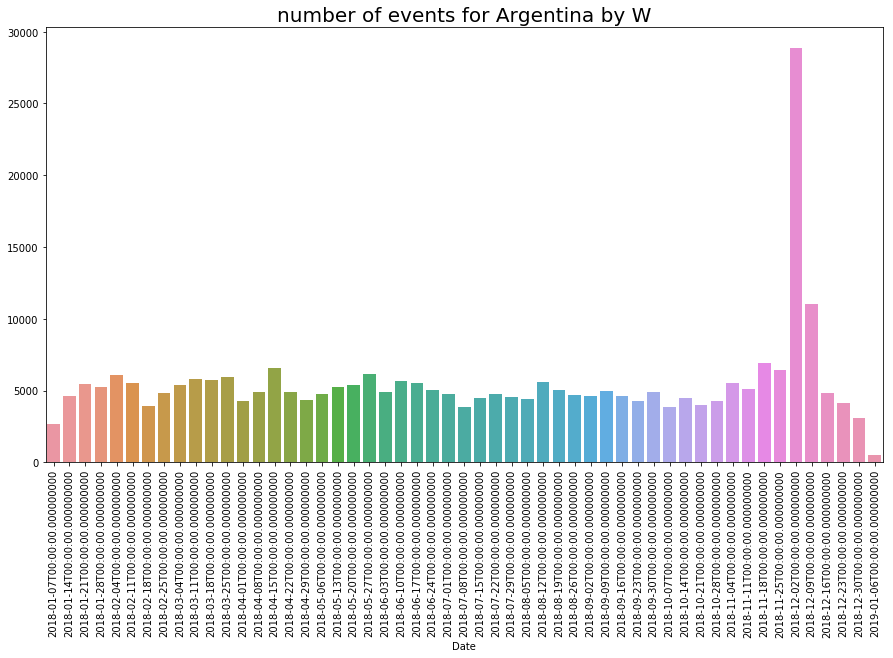

In [110]:
client = MongoClient()
collection = client.mention.data_mention

req = Request(collection)
req.requete2('Argentina','2018-07-01',plot=True)

In [112]:
##On peut acceder a la dataframe également via l'attribut df
req.df.head()

,Date,Event,Stakeholder
0,2018-12-03,807253059,UNITED STATES
1,2018-12-03,807185970,GERMANY
2,2018-12-03,807167789,WASHINGTON
3,2018-12-03,807148167,NEW DELHI
4,2018-12-03,807147551,


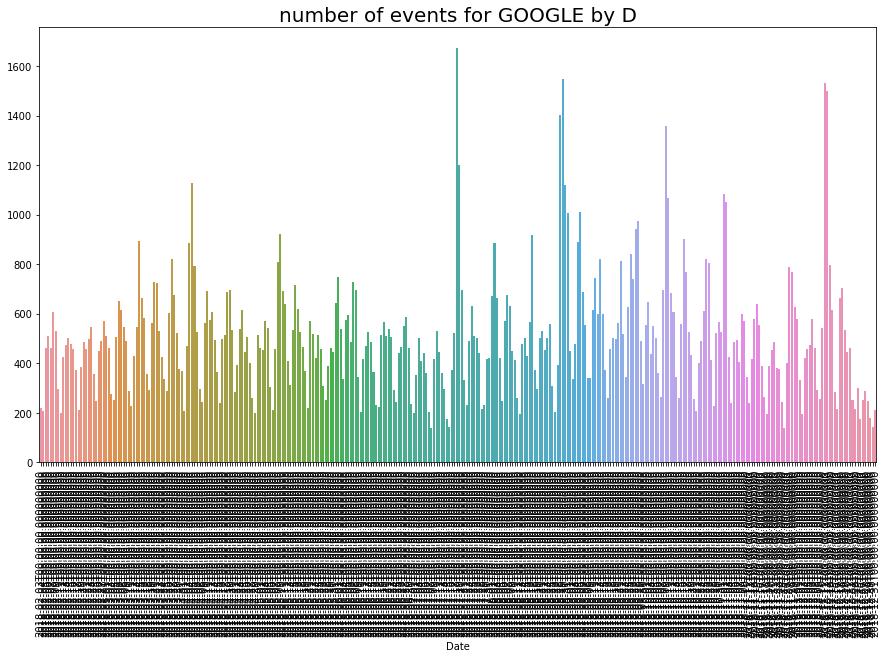

In [114]:
req = Request(client.mention.data_mention)
req.requete2('GOOGLE','2018-08-01',plot=True,Filt='D')

# Requete 5

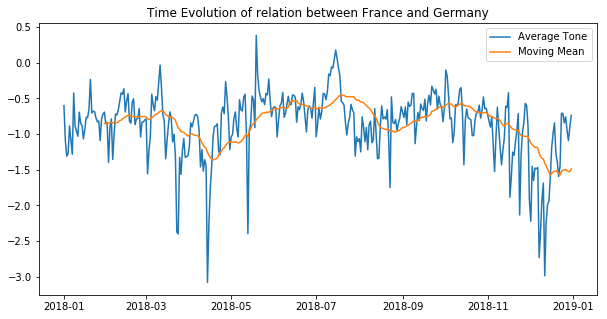

In [118]:
client = MongoClient()
collection = client.gkg.data_gkg
req5 = Request(collection)
req5.requete5('France', 'Germany')

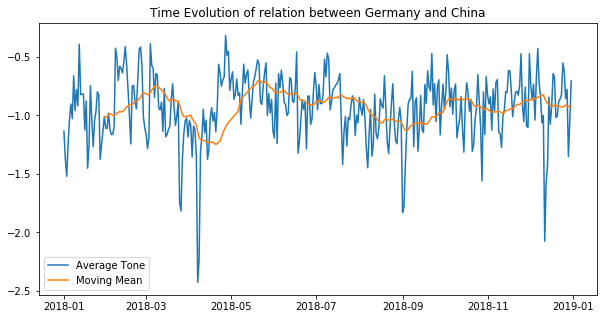

In [122]:
client = MongoClient()
collection = client.gkg.data_gkg
req5 = Request(collection)
req5.requete5('Germany', 'China')

In [125]:
#Comme d'habitude, la dataframe est stocké avec les arguments dans l'attribut df
req5.df.dropna().head()

,Average_Tone,Moving_Mean
Date,,
2018-01-30,-1.010719,-1.019003
2018-01-31,-1.109712,-1.018110
2018-02-01,-1.112416,-1.009350
2018-02-02,-0.980915,-0.991360
2018-02-03,-1.120084,-0.987275
